# Fase 4: Modeling

## Funciones auxiliares

In [50]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Diccionario global para almacenar los reportes de clasificación
reportes_guardados = {}

def guardar_reporte_clasificacion(nombre_modelo, y_true, y_pred, etiquetas=None, y_score=None):
    """
    Almacena el classification_report en un diccionario global.

    Parámetros:
    - nombre_modelo: clave para identificar el reporte (str)
    - y_true: etiquetas verdaderas
    - y_pred: etiquetas predichas por el modelo
    - etiquetas: lista opcional de nombres de clase
    """
    reporte = classification_report(
        y_true, y_pred, target_names=etiquetas if etiquetas else None, output_dict=True
    )

    # Agregar ROC AUC si es binario y se proporcionó y_score
    if y_score is not None and len(set(y_true)) == 2:
        auc = roc_auc_score(y_true, y_score)
        reporte['roc_auc'] = auc

    reportes_guardados[nombre_modelo] = reporte

def evaluar_modelo_clasificacion(y_true, y_pred, etiquetas=None, nombre_modelo='modelo', y_score=None):
    """
    Imprime la matriz de confusión y el classification report de un modelo de clasificación.

    Parámetros:
    - y_true: etiquetas verdaderas
    - y_pred: etiquetas predichas por el modelo
    - etiquetas: lista opcional de etiquetas para la matriz y el reporte
    - nombre_modelo: nombre identificador del modelo (str)
    - y_score: probabilidades de clase positiva (opcional, para calcular ROC AUC)
    """

    # Usar etiquetas numéricas (únicas de y_true/y_pred) para la matriz
    clases = sorted(list(set(y_true) | set(y_pred)))  # Asegura orden y cobertura

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=clases)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=etiquetas if etiquetas else clases,
                yticklabels=etiquetas if etiquetas else clases)
    plt.xlabel('Etiqueta Predicha')
    plt.ylabel('Etiqueta Verdadera')
    plt.title(f"Matriz de confusión - {nombre_modelo}")
    plt.tight_layout()
    plt.show()

    # Reporte de clasificación
    print("Reporte de Clasificación:\n")
    print(classification_report(y_true, y_pred, target_names=etiquetas if etiquetas else None))

    # ROC AUC
    if y_score is not None and len(set(y_true)) == 2:
        auc = roc_auc_score(y_true, y_score)
        print(f"ROC AUC Score para {nombre_modelo}: {auc:.4f}")

    # Guardar reporte
    guardar_reporte_clasificacion(nombre_modelo, y_true, y_pred, etiquetas, y_score)


In [52]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


def get_curva_roc(y_test, y_proba, nombre_modelo):
  fpr, tpr, thresholds = roc_curve(y_test, y_proba)

  roc_auc = roc_auc_score(y_test, y_proba)
  print(f"ROC AUC para {nombre_modelo}: {roc_auc:.4f}")

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], 'k--', label='Random')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Curva ROC - {nombre_modelo}')
  plt.legend()
  plt.grid(True)
  plt.show()

In [54]:
import pandas as pd

def exportar_reporte_clasificacion(nombre_modelo, nombre_archivo='reporte_clasificacion.csv'):
    """
    Exporta el reporte de clasificación guardado en el diccionario global a un archivo CSV.

    Parámetros:
    - nombre_modelo: nombre del modelo usado como clave en reportes_guardados
    - nombre_archivo: nombre del archivo CSV de salida
    """
    if nombre_modelo not in reportes_guardados:
        print(f"No se encontró el reporte para el modelo '{nombre_modelo}'.")
        return

    reporte = reportes_guardados[nombre_modelo]

    # Convertir el dict a DataFrame
    df_reporte = pd.DataFrame(reporte).T  # Transponer para que las clases sean filas

    # Exportar csv
    path = "/content/drive/MyDrive/reportes/"
    df_reporte.to_csv(path + nombre_archivo, index=True)
    print(f"Reporte exportado correctamente a: {path + nombre_archivo}")


In [56]:
import joblib
import os

def guardar_modelo(modelo, nombre_modelo):
    """
    Guarda el modelo serializado en formato .pkl en Google Drive.

    Parámetros:
    - modelo: objeto del modelo entrenado
    - nombre_modelo: nombre del archivo a guardar (sin extensión)
    """
    ruta_directorio = '../models_ML'
    ruta_modelo = os.path.join(ruta_directorio, f'{nombre_modelo}.pkl')

    # Crear carpeta si no existe
    os.makedirs(ruta_directorio, exist_ok=True)

    # Guardar el modelo
    joblib.dump(modelo, ruta_modelo)
    print(f"Modelo guardado exitosamente en: {ruta_modelo}")

## Aprendizaje Supervisado - Clasificación

El aprendizaje supervisado en clasificación es una técnica de machine learning donde el modelo aprende a predecir una etiqueta o categoría a partir de datos previamente etiquetados. Durante el entrenamiento, el algoritmo recibe ejemplos con sus respectivas clases correctas y busca encontrar patrones que le permitan clasificar correctamente nuevos datos.








Importamos nuestro dataset balanceado

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
import sklearn
print(sklearn.__version__)

1.5.1


In [3]:
ds_clas = pd.read_csv('../data/dataset_balanceado.csv')
ds_clas.head()

MinTemp   MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0  0.429280  0.387524  0.013477       0.456522      0.240741      0.263158   
1  0.526055  0.389414  0.002156       0.315217      0.240741      0.263158   
2  0.364764  0.376181  0.000000       0.152174      0.037037      0.192982   
3  0.342432  0.391304  0.000000       0.260870      0.111111      0.228070   
4  0.491315  0.387524  0.022426       0.500000      0.277778      0.385965   

   Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  ...  RainToday  \
0         0.92         0.67     0.570370     0.590654  ...        1.0   
1         0.75         0.52     0.662963     0.682243  ...        0.0   
2         0.81         0.56     0.762963     0.755140  ...        0.0   
3         0.71         0.46     0.779630     0.738318  ...        0.0   
4         0.62         0.62     0.609259     0.562617  ...        0.8   

    RISK_MM  Location_le  Risk_MM_cat_le  Rainfall_cat_le  Estacion_le  \
0  0.002156          0.0        1.000000              1.0          0.0   
1  0.000000          0.0        1.000000              1.0          0.0   
2  0.000000          0.0        1.000000              1.0          0.0   
3  0.000000          0.0        1.000000              1.0          0.0   
4  0.043666          0.0        0.666667              0.0          0.0   

   WindGustDir_le  WindDir9am_le  WindDir3pm_le  RainTomorrow  
0          0.4375         0.7500         0.8125           0.0  
1          0.7500         0.6875         0.7500           0.0  
2          0.8125         0.3125         0.7500           0.0  
3          0.3125         0.3125         0.2500           0.0  
4          0.3750         0.3125         0.3750           1.0  

[5 rows x 24 columns]

In [5]:
# Random state
rs = 123

# Variables predictoras
feature_cols = [col for col in ds_clas.columns if col != 'RainTomorrow']

# Variable objetivo
target = 'RainTomorrow'

In [7]:
X = ds_clas[feature_cols]
y = ds_clas[target]

In [9]:
print("X: ", X.shape)
print("y: ", y.shape)
print("Cantidad de datos para la clase 0 y 1: ", y.value_counts())

X:  (221312, 23)
y:  (221312,)
Cantidad de datos para la clase 0 y 1:  RainTomorrow
0.0    110656
1.0    110656
Name: count, dtype: int64


### Selección de las mejores variables para clasificar

Este código utiliza el método SelectKBest con la función estadística f_classif para seleccionar las variables más relevantes para un problema de clasificación. Lo que hace es calcular una puntuación F para cada variable, que mide qué tan bien cada una distingue entre las clases de la variable objetivo y. Luego, se ordenan las variables por su puntaje de mayor a menor y se seleccionan las 5 mejores más la variable Location y Estacion del año. Esta selección es importante porque permite reducir la dimensionalidad del conjunto de datos, eliminando variables poco útiles, lo que puede mejorar el rendimiento del modelo, reducir el riesgo de overfitting y acelerar el entrenamiento.

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

scores = selector.scores_

scores

array([4.47596483e+03, 2.52399899e+03, 9.57594584e+03, 9.48640180e+03,
       1.57184514e+03, 1.17224608e+03, 1.18218539e+04, 2.12849743e+04,
       1.80703493e+04, 1.59319162e+04, 2.63193194e+04, 3.94768067e+04,
       1.18010122e+02, 4.72226820e+03, 2.02661553e+04, 5.56475045e+04,
       0.00000000e+00, 3.83597990e+04, 7.24665495e+03, 0.00000000e+00,
       3.31518072e+02, 6.12684332e+01, 4.56243148e+01])

In [13]:
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'F_Score': selector.scores_
})

# Ordenamos de mayor a menor
feature_scores = feature_scores.sort_values(by='F_Score', ascending=False)

feature_scores

Feature       F_Score
15          RISK_MM  55647.504522
11         Cloud3pm  39476.806663
17   Risk_MM_cat_le  38359.799021
10         Cloud9am  26319.319354
7       Humidity3pm  21284.974283
14        RainToday  20266.155253
8       Pressure9am  18070.349346
9       Pressure3pm  15931.916177
6       Humidity9am  11821.853884
2          Rainfall   9575.945844
3     WindGustSpeed   9486.401796
18  Rainfall_cat_le   7246.654954
13          Temp3pm   4722.268196
0           MinTemp   4475.964834
1           MaxTemp   2523.998987
4      WindSpeed9am   1571.845136
5      WindSpeed3pm   1172.246084
20   WindGustDir_le    331.518072
12          Temp9am    118.010122
21    WindDir9am_le     61.268433
22    WindDir3pm_le     45.624315
16      Location_le      0.000000
19      Estacion_le      0.000000

In [15]:
# Elegimos los 5 mejores variables
top_features = feature_scores.head(6)['Feature'].tolist()
X_top = X[top_features]
X_top = X_top[['Humidity3pm', 'Cloud3pm', 'Cloud9am', 'RainToday']]
X_top.head()

Humidity3pm  Cloud3pm  Cloud9am  RainToday
0         0.67     0.625     0.625        1.0
1         0.52     0.625     0.625        0.0
2         0.56     0.625     0.625        0.0
3         0.46     0.625     0.625        0.0
4         0.62     0.625     0.625        0.8

In [17]:
X_top = pd.concat([X_top, X['Location_le'], X['Estacion_le']], axis=1)
X_top.head()

Humidity3pm  Cloud3pm  Cloud9am  RainToday  Location_le  Estacion_le
0         0.67     0.625     0.625        1.0          0.0          0.0
1         0.52     0.625     0.625        0.0          0.0          0.0
2         0.56     0.625     0.625        0.0          0.0          0.0
3         0.46     0.625     0.625        0.0          0.0          0.0
4         0.62     0.625     0.625        0.8          0.0          0.0

In [23]:
# from sklearn.preprocessing import MinMaxScaler
# import joblib

# cat = pd.read_csv('../data/data_cat.csv')
# X_to_scale = cat[X_top.columns]

# scaler = MinMaxScaler()
# scaler.fit(X_to_scale)
# joblib.dump(scaler, "../models_ML/scaler_cla.pkl")

['../models_ML/scaler_cla.pkl']

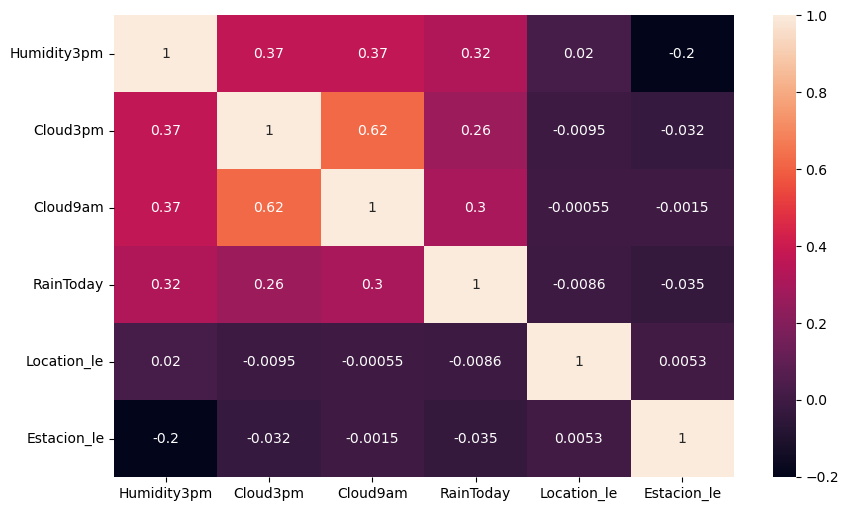

In [19]:
plt.figure(figsize=(10, 6))
sns.heatmap(X_top.corr(), annot=True)
plt.show()

### Split de datos estratificado

Creamos nuestras variables X e y de train y de test de manera estratificada. Este código utiliza la técnica StratifiedShuffleSplit de scikit-learn para dividir un conjunto de datos en entrenamiento y prueba, asegurando que la proporción de clases en la variable objetivo (y) se mantenga equilibrada en ambos subconjuntos. Esto es especialmente importante en problemas de clasificación con clases desbalanceadas, ya que garantiza que todas las clases estén representadas de forma proporcional.

In [122]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=rs)

In [124]:
# Get the index values from the generator
train_idx, test_idx = next(sss.split(X, y))

# Create the data sets
X_train = ds_clas.loc[train_idx, X_top.columns.to_list()]
y_train = ds_clas.loc[train_idx, target]

X_test = ds_clas.loc[test_idx, X_top.columns.to_list()]
y_test = ds_clas.loc[test_idx, target]

In [126]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((154918, 6), (154918,), (66394, 6), (66394,))

In [128]:
print(y_train.value_counts(),"\n")
print(y_train.value_counts(normalize=True),"\n")
print(y_test.value_counts(),"\n")
print(y_test.value_counts(normalize=True),"\n")

RainTomorrow
0.0    77459
1.0    77459
Name: count, dtype: int64 

RainTomorrow
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64 

RainTomorrow
0.0    33197
1.0    33197
Name: count, dtype: int64 

RainTomorrow
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64 



## Regresión Logística con Cross Validation

La regresión logística es un algoritmo de aprendizaje supervisado utilizado para resolver problemas de clasificación binaria o multiclase. A diferencia de la regresión lineal, su objetivo no es predecir un valor continuo, sino la probabilidad de que una observación pertenezca a una clase específica. Utiliza una función sigmoide para transformar la salida en un valor entre 0 y 1, que luego se interpreta como una probabilidad.








Importamos el modelo de regresión logística con validación cruzada

In [130]:
from sklearn.linear_model import LogisticRegressionCV

# Entrenar modelo con validación cruzada
model = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty='l2',
    solver='lbfgs',     # Cambiar si usas otra penalización
    scoring='accuracy',
    max_iter=1000,
    random_state=rs,
    n_jobs=-1
)

model.fit(X_train, y_train)

LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=-1, random_state=123,
                     scoring='accuracy')

In [132]:
y_pred_log = model.predict(X_test)
y_proba_log = model.predict_proba(X_test)[:, 1]

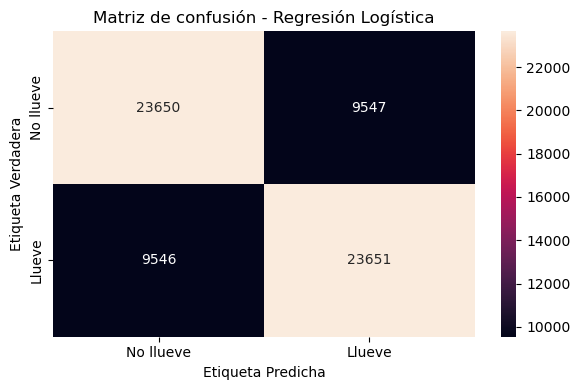

Reporte de Clasificación:

              precision    recall  f1-score   support

   No llueve       0.71      0.71      0.71     33197
      Llueve       0.71      0.71      0.71     33197

    accuracy                           0.71     66394
   macro avg       0.71      0.71      0.71     66394
weighted avg       0.71      0.71      0.71     66394

ROC AUC Score para Regresión Logística: 0.7873


In [134]:
evaluar_modelo_clasificacion(
    y_true=y_test,
    y_pred=y_pred_log,
    etiquetas=['No llueve', 'Llueve'],
    nombre_modelo='Regresión Logística',
    y_score=y_proba_log
)

ROC AUC para Regresión Logística: 0.7873


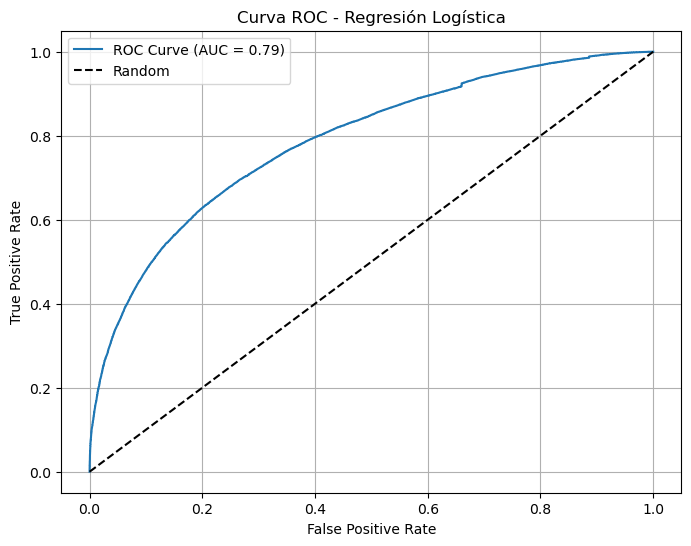

In [136]:
get_curva_roc(y_test, y_proba_log, 'Regresión Logística')

## Árbol de Decisión de clasificación con GridSeachCV

El Árbol de Decisión de clasificación es un modelo supervisado que organiza los datos en una estructura jerárquica de decisiones basadas en reglas. Para optimizar su rendimiento, se usa GridSearchCV, que busca automáticamente la mejor combinación de hiperparámetros como la profundidad del árbol, el criterio de división y el número mínimo de muestras por nodo. Este enfoque mejora la precisión del modelo al encontrar la configuración óptima, evitando sobreajuste y asegurando una mejor generalización en datos no vistos.








importamos el modelo de arbol de decision

In [138]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Definir el clasificador base
dt = DecisionTreeClassifier(random_state=rs)

# Definir la grilla de hiperparámetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Crear el GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Entrenar
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=1)

In [140]:
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score (CV):", grid_search.best_score_)

Mejores parámetros: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Mejor score (CV): 0.8402316026915269


In [142]:
# Obtener el mejor modelo
best_dt = grid_search.best_estimator_

In [144]:
# Predecir con el mejor modelo
y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]

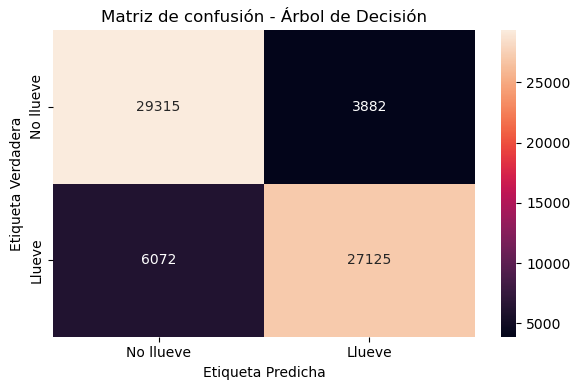

Reporte de Clasificación:

              precision    recall  f1-score   support

   No llueve       0.83      0.88      0.85     33197
      Llueve       0.87      0.82      0.84     33197

    accuracy                           0.85     66394
   macro avg       0.85      0.85      0.85     66394
weighted avg       0.85      0.85      0.85     66394

ROC AUC Score para Árbol de Decisión: 0.9079


In [146]:
evaluar_modelo_clasificacion(
    y_test,
    y_pred_dt,
    etiquetas=['No llueve', 'Llueve'],
    nombre_modelo='Árbol de Decisión',
    y_score=y_proba_dt
)

ROC AUC para Árbol de Decisión: 0.9079


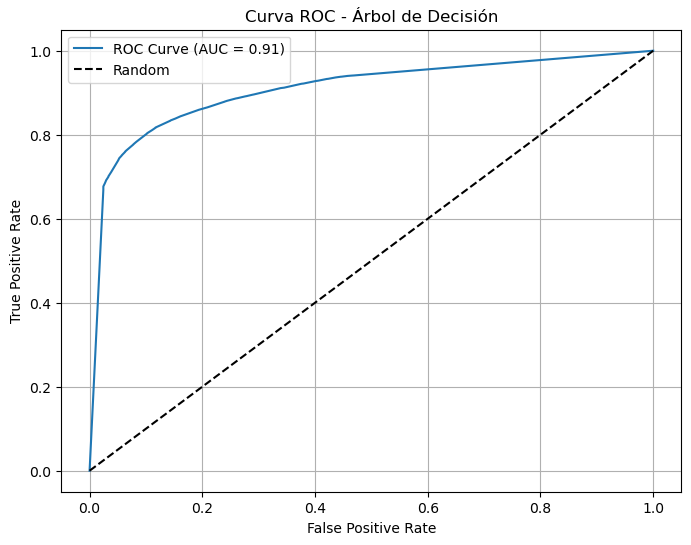

In [148]:
get_curva_roc(y_test, y_proba_dt, 'Árbol de Decisión')

## Random Forest GridSearchCV

In [153]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=rs)

# Grilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],      # Número de árboles
    'max_depth': [None, 10, 20],          # Profundidad máxima del árbol
    'max_features': ['sqrt', 'log2'],     # Subconjunto de features en cada split
    'min_samples_split': [2, 5]           # Mínimas muestras para dividir un nodo
}

# Ejemplo de uso con GridSearchCV
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                      # Validación cruzada 5-fold
    scoring='accuracy',        # Métrica de evaluación
    n_jobs=-1,                 # Usa todos los núcleos disponibles
    verbose=2
)

# Entrenar
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [157]:
print("Mejores parámetros:", grid_rf.best_params_)
print("Mejor score (CV):", grid_rf.best_score_)

Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 300}
Mejor score (CV): 0.8457248447279535


In [161]:
# Obtener el mejor modelo
best_rf = grid_rf.best_estimator_

In [163]:
# Predecir con el mejor modelo
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

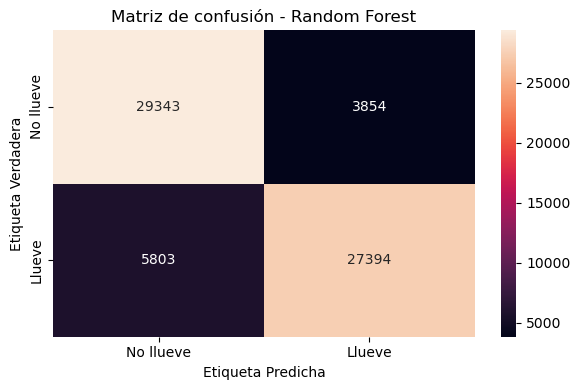

Reporte de Clasificación:

              precision    recall  f1-score   support

   No llueve       0.83      0.88      0.86     33197
      Llueve       0.88      0.83      0.85     33197

    accuracy                           0.85     66394
   macro avg       0.86      0.85      0.85     66394
weighted avg       0.86      0.85      0.85     66394

ROC AUC Score para Random Forest: 0.9242


In [165]:
evaluar_modelo_clasificacion(
    y_test,
    y_pred_rf,
    etiquetas=['No llueve', 'Llueve'],
    nombre_modelo='Random Forest',
    y_score=y_proba_rf
)

ROC AUC para Random Forest: 0.9242


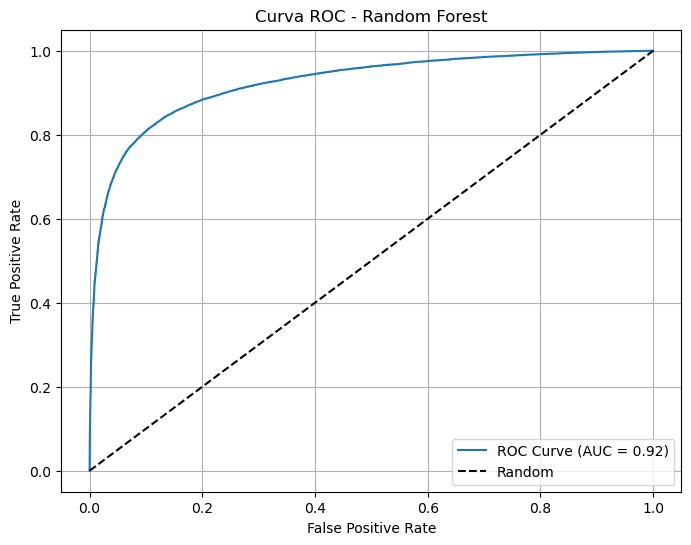

In [167]:
get_curva_roc(y_test, y_proba_rf, 'Random Forest')

## GradientBoosting

In [170]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(random_state=rs)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],      # Tasa de aprendizaje
    'max_iter': [100, 200, 300],            # Número de iteraciones (n_estimators)
    'max_depth': [None, 5, 10],             # Profundidad máxima de los árboles
    'min_samples_leaf': [20, 50, 100],      # Mínimas muestras por hoja
    'l2_regularization': [0.0, 1.0, 10.0]   # Regularización L2
}

grid_hgb = GridSearchCV(
    estimator=hgb,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',     # Cambia a 'f1', 'roc_auc' según tu caso
    n_jobs=-1,
    verbose=2
)

# Entrenar
grid_hgb.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3, estimator=HistGradientBoostingClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'l2_regularization': [0.0, 1.0, 10.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [None, 5, 10],
                         'max_iter': [100, 200, 300],
                         'min_samples_leaf': [20, 50, 100]},
             scoring='accuracy', verbose=2)

In [172]:
print("Mejores parámetros:", grid_hgb.best_params_)
print("Mejor score (CV):", grid_hgb.best_score_)

Mejores parámetros: {'l2_regularization': 0.0, 'learning_rate': 0.2, 'max_depth': None, 'max_iter': 300, 'min_samples_leaf': 20}
Mejor score (CV): 0.8443111890099497


In [174]:
# Obtener el mejor modelo
best_hgb = grid_hgb.best_estimator_

In [176]:
# Predecir con el mejor modelo
y_pred_hgb = best_hgb.predict(X_test)
y_proba_hgb = best_hgb.predict_proba(X_test)[:, 1]

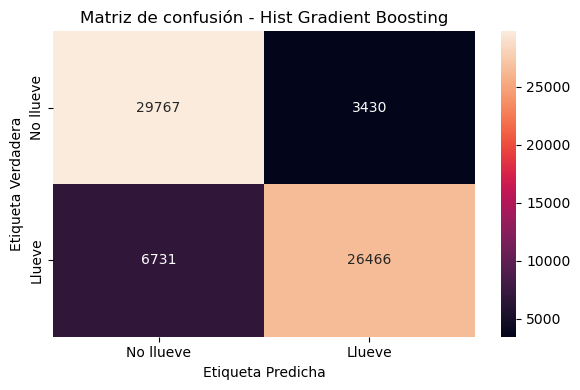

Reporte de Clasificación:

              precision    recall  f1-score   support

   No llueve       0.82      0.90      0.85     33197
      Llueve       0.89      0.80      0.84     33197

    accuracy                           0.85     66394
   macro avg       0.85      0.85      0.85     66394
weighted avg       0.85      0.85      0.85     66394

ROC AUC Score para Hist Gradient Boosting: 0.9226


In [178]:
evaluar_modelo_clasificacion(
    y_test,
    y_pred_hgb,
    etiquetas=['No llueve', 'Llueve'],
    nombre_modelo='Hist Gradient Boosting',
    y_score=y_proba_hgb
)

ROC AUC para Hist Gradient Boosting: 0.9226


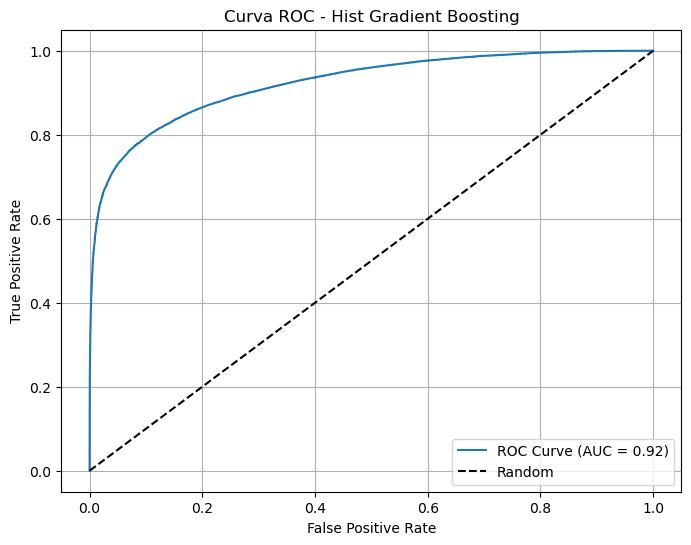

In [180]:
get_curva_roc(y_test, y_proba_hgb, 'Hist Gradient Boosting')

In [182]:
reportes_guardados

{'Regresión Logística': {'No llueve': {'precision': 0.7124352331606217,
   'recall': 0.7124137723288249,
   'f1-score': 0.7124245025831036,
   'support': 33197.0},
  'Llueve': {'precision': 0.712422435086451,
   'recall': 0.7124438955327289,
   'f1-score': 0.712433165147978,
   'support': 33197.0},
  'accuracy': 0.7124288339307768,
  'macro avg': {'precision': 0.7124288341235363,
   'recall': 0.7124288339307769,
   'f1-score': 0.7124288338655409,
   'support': 66394.0},
  'weighted avg': {'precision': 0.7124288341235364,
   'recall': 0.7124288339307768,
   'f1-score': 0.7124288338655409,
   'support': 66394.0},
  'roc_auc': 0.7872611852616068},
 'Árbol de Decisión': {'No llueve': {'precision': 0.8284115635685422,
   'recall': 0.8830617224447992,
   'f1-score': 0.8548641082468215,
   'support': 33197.0},
  'Llueve': {'precision': 0.874802463959751,
   'recall': 0.817091905895111,
   'f1-score': 0.8449629306585259,
   'support': 33197.0},
  'accuracy': 0.8500768141699551,
  'macro avg': 

In [184]:
# Lista para almacenar los datos tabulados
filas = []

# Recorremos cada modelo y sus métricas
for modelo, metricas in reportes_guardados.items():
    fila = {
        'Modelo': modelo,
        'Accuracy': metricas['accuracy'],
        'ROC AUC': metricas['roc_auc'],
        'Precision (No llueve)': metricas['No llueve']['precision'],
        'Recall (No llueve)': metricas['No llueve']['recall'],
        'F1-score (No llueve)': metricas['No llueve']['f1-score'],
        'Precision (Llueve)': metricas['Llueve']['precision'],
        'Recall (Llueve)': metricas['Llueve']['recall'],
        'F1-score (Llueve)': metricas['Llueve']['f1-score'],
        'F1 Macro': metricas['macro avg']['f1-score'],
        'F1 Weighted': metricas['weighted avg']['f1-score']
    }
    filas.append(fila)

# Crear DataFrame
df_resultados = pd.DataFrame(filas)
df_resultados

Modelo  Accuracy   ROC AUC  Precision (No llueve)  \
0     Regresión Logística  0.712429  0.787261               0.712435   
1       Árbol de Decisión  0.850077  0.907914               0.828412   
2           Random Forest  0.854550  0.924202               0.834889   
3  Hist Gradient Boosting  0.846959  0.922617               0.815579   

   Recall (No llueve)  F1-score (No llueve)  Precision (Llueve)  \
0            0.712414              0.712425            0.712422   
1            0.883062              0.854864            0.874802   
2            0.883905              0.858698            0.876664   
3            0.896677              0.854208            0.885269   

   Recall (Llueve)  F1-score (Llueve)  F1 Macro  F1 Weighted  
0         0.712444           0.712433  0.712429     0.712429  
1         0.817092           0.844963  0.849914     0.849914  
2         0.825195           0.850151  0.854425     0.854425  
3         0.797241           0.838952  0.846580     0.846580

In [188]:
# Guardar como CSV
df_resultados.to_csv('../metrics/classification/metricas_modelos_clasificacion.csv', index=False)

# Fase 5: Evaluation

Para la etapa final del análisis, realizaremos una evaluación exhaustiva de los modelos de clasificación, determinando cuál ofrece el mejor rendimiento. Para ello, utilizaremos métricas clave que nos ayudarán a medir diferentes aspectos de su desempeño:

Precision: Indica la proporción de predicciones positivas que realmente son correctas, evitando falsos positivos.
Recall: Mide la capacidad del modelo para identificar correctamente todas las instancias positivas, reduciendo falsos negativos.
F1-score: Es una métrica equilibrada que combina precision y recall, útil cuando hay un compromiso entre ambos.
Accuracy: Refleja el porcentaje total de predicciones correctas, considerando todas las clases.
ROC AUC: Evalúa la calidad del modelo en la clasificación binaria, analizando su capacidad para distinguir entre clases positivas y negativas.
Al analizar estas métricas en conjunto, podremos seleccionar el modelo que mejor se adapte a nuestros objetivos y garantice una clasificación eficiente y confiable.

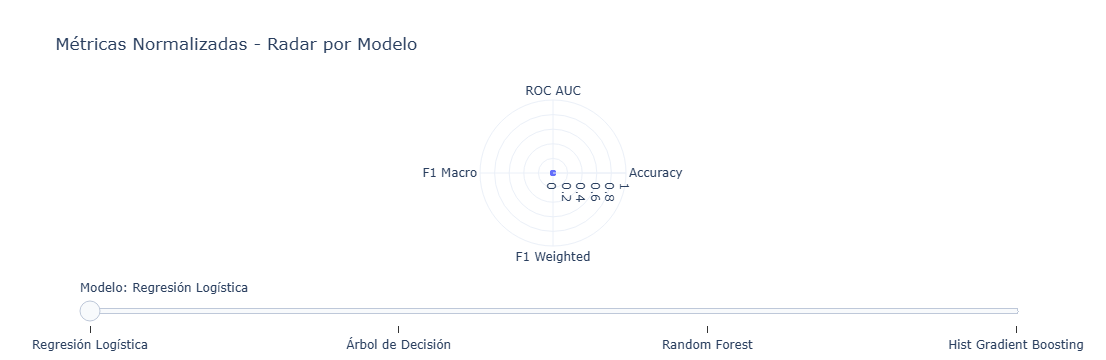

In [196]:
# Normalizamos las métricas a rango [0, 1] para compararlas de forma equitativa
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
metricas = ['Accuracy', 'ROC AUC', 'F1 Macro', 'F1 Weighted']
df_scaled = df_resultados.copy()
df_scaled[metricas] = scaler.fit_transform(df_resultados[metricas])

# Preparamos trazas individuales para cada modelo
fig = go.Figure()

for i, row in df_scaled.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[metricas].tolist(),
        theta=metricas,
        fill='toself',
        name=row['Modelo'],
        visible=(i == 0)  # solo el primero visible al inicio
    ))

# Creamos el slider
steps = []
for i, modelo in enumerate(df_scaled['Modelo']):
    step = dict(
        method="update",
        args=[{"visible": [j == i for j in range(len(df_scaled))]},
              {"title": f"Métricas Normalizadas - {modelo}"}],
        label=modelo
    )
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Modelo: "},
    pad={"t": 30},
    steps=steps
)]

# Configuramos el layout
fig.update_layout(
    title="Métricas Normalizadas - Radar por Modelo",
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 1])
    ),
    sliders=sliders,
    showlegend=False,
    template="plotly_white"
)

fig.show()

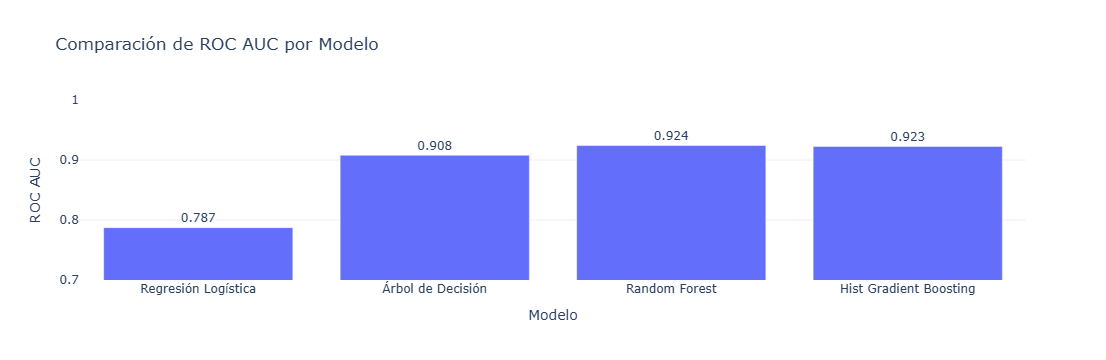

In [198]:
fig = px.bar(
    df_resultados,
    x='Modelo',
    y='ROC AUC',
    text='ROC AUC',
    title='Comparación de ROC AUC por Modelo',
    template='plotly_white'
)

fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_layout(yaxis=dict(range=[0.7, 1.0]))

fig.show()

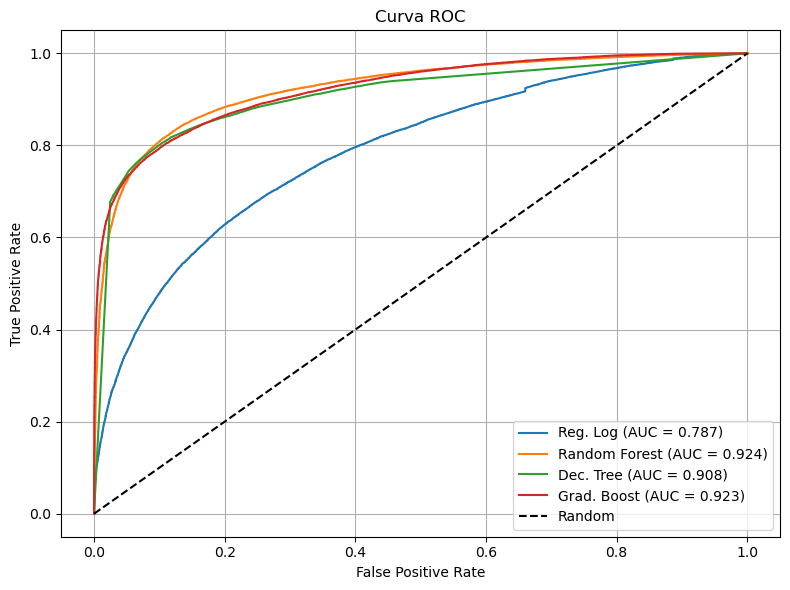

In [210]:
# Cálculo de curvas ROC
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
fpr_hgb, tpr_hgb, _ = roc_curve(y_test, y_proba_hgb)

# Cálculo de ROC AUC
roc_auc_log = roc_auc_score(y_test, y_proba_log)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
roc_auc_hgb = roc_auc_score(y_test, y_proba_hgb)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Reg. Log (AUC = {roc_auc_log:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot(fpr_dt, tpr_dt, label=f'Dec. Tree (AUC = {roc_auc_dt:.3f})')
plt.plot(fpr_hgb, tpr_hgb, label=f'Grad. Boost (AUC = {roc_auc_hgb:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


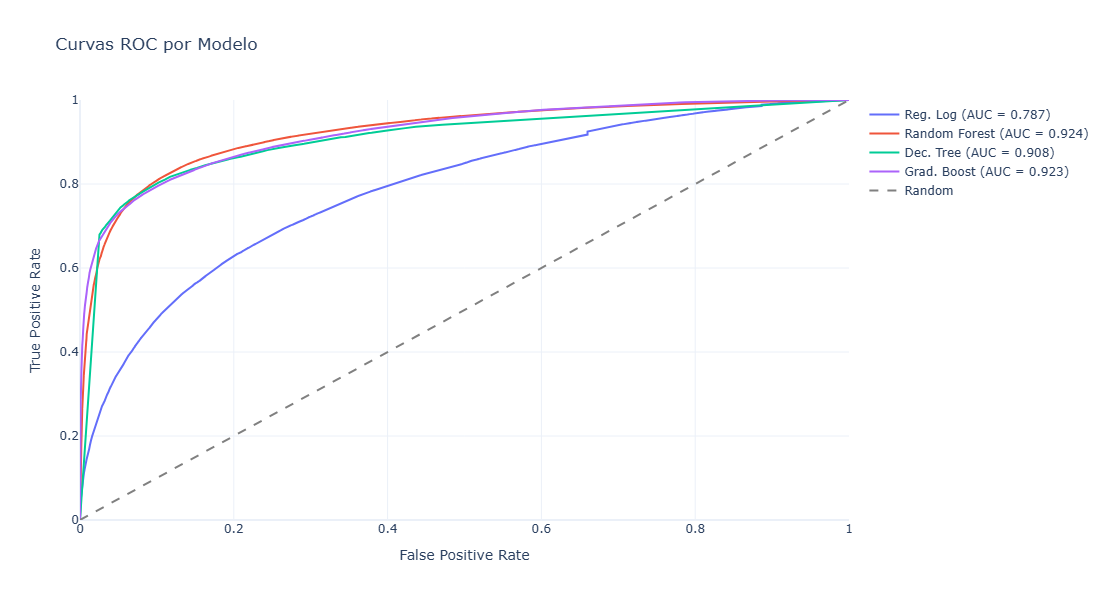

In [212]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=fpr_log, y=tpr_log, mode='lines',
                         name=f'Reg. Log (AUC = {roc_auc_log:.3f})'))
fig.add_trace(go.Scatter(x=fpr_rf, y=tpr_rf, mode='lines',
                         name=f'Random Forest (AUC = {roc_auc_rf:.3f})'))
fig.add_trace(go.Scatter(x=fpr_dt, y=tpr_dt, mode='lines',
                         name=f'Dec. Tree (AUC = {roc_auc_dt:.3f})'))
fig.add_trace(go.Scatter(x=fpr_hgb, y=tpr_hgb, mode='lines',
                         name=f'Grad. Boost (AUC = {roc_auc_hgb:.3f})'))

# Línea aleatoria
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines',
                         name='Random', line=dict(dash='dash', color='gray')))

fig.update_layout(
    title='Curvas ROC por Modelo',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    xaxis=dict(range=[0, 1]),
    yaxis=dict(range=[0, 1]),
    template='plotly_white',
    width=800,
    height=600
)

fig.show()


Exportamos los 2 mejores modelos de clasificación

In [214]:
guardar_modelo(best_rf, 'random_forest_classifier')

Modelo guardado exitosamente en: ../models_ML\random_forest_classifier.pkl


In [216]:
guardar_modelo(best_hgb, 'gradient_boosting_classifier')

Modelo guardado exitosamente en: ../models_ML\gradient_boosting_classifier.pkl
